# Plot partial dependence plots (PDP) for chamise predictors
Last updated: Kevin Varga, 11/27/2024

**Inputs:**
* Fuel specific random forest models

**Outputs:**
* Partial dependence plots (PDP) for each predictor for chamise

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [5]:
pred_path = '/home/sbarc/students/varga/nasa/ch1/data/site_predictors/'
output_path = '/home/sbarc/students/varga/nasa/ch1/figures/random_forest/'
param_path = '/home/sbarc/students/varga/nasa/ch1/data/random_forest/'

In [5]:
fuel_type = 'chamise'
# Read in chamise predictors
features = pd.read_csv(pred_path + fuel_type + '.csv', index_col=[0,1], parse_dates=True, infer_datetime_format=True)

# Read in optimized parameters
param_df = pd.read_csv(param_path + 'param_tuning.csv', index_col='fuel')

In [6]:
# Create random forest model with non-scaled predictors in order of chamise predictor importance

# Extract LFM percent as target, and drop unneeded columns from df for random forest
targets = features['percent']
features.drop(columns=['latitude', 'longitude', 'percent', 'fuel'], inplace=True)

# Convert temperature to C for plotting
features['temp90mean'] = features['temp90mean'] - 273.15

# Extract optimized parameters from param_df
n_est = param_df.loc[fuel_type]['n_estimators']
n_split = param_df.loc[fuel_type]['min_samples_split']
n_leaf = param_df.loc[fuel_type]['min_samples_leaf']
max_feature_style = param_df.loc[fuel_type]['max_features']
n_depth = param_df.loc[fuel_type]['max_depth']
if pd.isna(n_depth) == True: n_depth = None
bootstrap_style = param_df.loc[fuel_type]['bootstrap']

# Change the order of the predictors to align with chamise importance order
col_order = ['precip90sum','temp90mean','rad150mean','daylength','nirv',
             'somo7mean','rh150mean','cwd90sum','precip30sum']
features = features[col_order]

# Do not scale predictor variables for plot readability
# Create standardized scaler and scale predictors to a mean zero scale to reduce bias
#scaler = StandardScaler().fit(features)
#features = pd.DataFrame(scaler.transform(features), index=features.index, columns=features.columns.values)

# Initiate random forest model
rf = RandomForestRegressor(n_est, min_samples_split=n_split, min_samples_leaf = n_leaf, max_features=max_feature_style, 
                           max_depth=n_depth, bootstrap=bootstrap_style, n_jobs=-1, random_state=42)

# Train the model all of the data
rf.fit(features, targets)

RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      min_samples_leaf=2, n_estimators=800, n_jobs=-1,
                      random_state=42)

In [7]:
# Rename column labels to use for plot labels
col_labels = ['90-day Precip (mm)','90-day Temp (C)','150-day SolRad (W/m2)','Day Length (hrs)','NIRv',
            '7-day SMOIS (m3/m3)','150-day RH (%)','90-day CWD (mm)','30-day Precip (mm)']
features = features.rename(columns=dict(zip(features.columns, col_labels)))

In [8]:
# Set plot parameters
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

plt.rcParams['figure.facecolor'] = 'white'

CPU times: user 28.9 s, sys: 12.1 s, total: 41 s
Wall time: 39.1 s


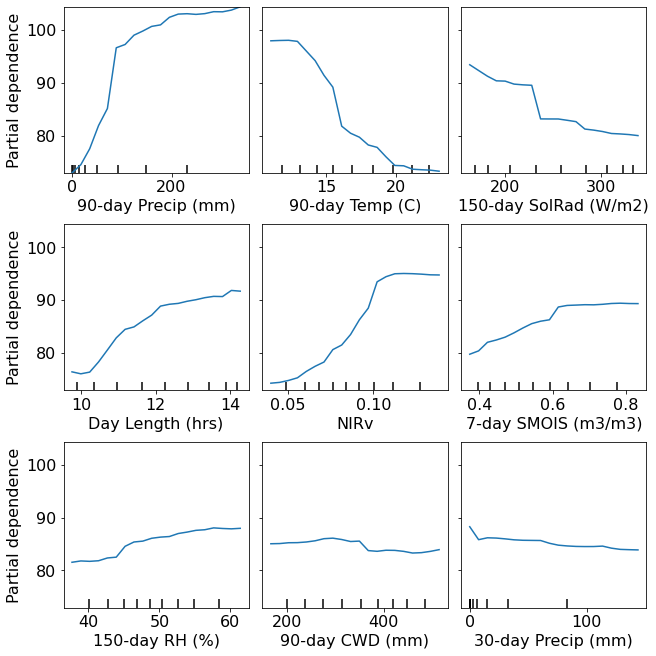

In [9]:
%%time

common_params = {
    "subsample": 50,
    "n_jobs": -1,
    "grid_resolution": 20,
    "random_state": 42,
}

features_info = {
    'features': list(features.columns),
    #type of partial dependence plot
    'kind': 'average',
}

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(9, 9), constrained_layout=True, facecolor='white')

display = PartialDependenceDisplay.from_estimator(
    rf,
    features,
    **features_info,
    ax=ax,
    **common_params,
)

fig.savefig(output_path + 'chamise_pdp.png', dpi = 500, bbox_inches='tight');